In [18]:
from tms_risk.utils.data import Subject, get_tms_subjects, get_tms_conditions
import seaborn as sns
from tqdm.contrib.itertools import product
import pandas as pd

In [66]:
subjects = [Subject(sub) for sub in get_tms_subjects(exclude_outliers=True)]

In [53]:
pars = []
keys = []

for sub, session in product(subjects, [1,2,3]):

    try:
        pars.append(sub.get_prf_parameters_volume(session, smoothed=True, retroicor=False, denoise=True, cross_validated=False, roi='NPCr'))
        keys.append((sub.subject, session))
    except Exception as e:
        print(e)


  0%|          | 0/105 [00:00<?, ?it/s]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new 

File not found: '/data/ds-tmsrisk/derivatives/encoding_model.denoise.smoothed/sub-10/ses-1/func/sub-10_ses-1_desc-mu.optim_space-t1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new 

File not found: '/data/ds-tmsrisk/derivatives/encoding_model.denoise.smoothed/sub-45/ses-2/func/sub-45_ses-2_desc-mu.optim_space-t1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new 

File not found: '/data/ds-tmsrisk/derivatives/encoding_model.denoise.smoothed/sub-62/ses-2/func/sub-62_ses-2_desc-mu.optim_space-t1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new 

File not found: '/data/ds-tmsrisk/derivatives/encoding_model.denoise.smoothed/sub-72/ses-2/func/sub-72_ses-2_desc-mu.optim_space-t1w_pars.nii.gz'


/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(img, resampled_data, target_affine)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/image/resampling.py:627: UserWarning: Data array used to create a new 

In [54]:
pars = pd.concat(pars, keys=keys, names=['subject', 'session'])

In [91]:
tms_conditions = get_tms_conditions()
for key in tms_conditions:
    tms_conditions[key][1] = 'baseline'

pars['stimulation_conditon'] = pars.reset_index().apply(lambda d: tms_conditions[d['subject']][d['session']],  axis=1).values

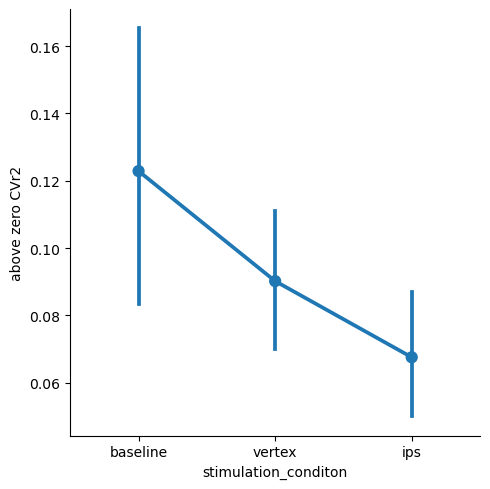

In [95]:
cvr2 = pars.groupby(['subject', 'session', 'stimulation_conditon'])['cvr2'].apply(lambda d: (d> 0.0).mean()).to_frame('above zero CVr2').reset_index()

sns.catplot(cvr2.reset_index(), x='stimulation_conditon', y='above zero CVr2', kind='point')

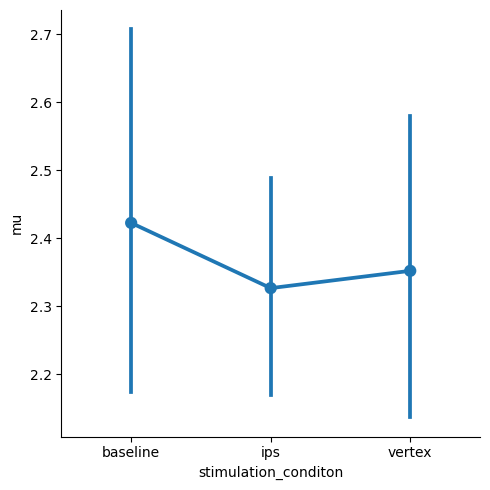

In [99]:
tmp = pars[pars.cvr2 > 0.0].groupby(['subject', 'stimulation_conditon']).mean().reset_index()


sns.catplot(tmp, x='stimulation_conditon', y='mu', kind='point')

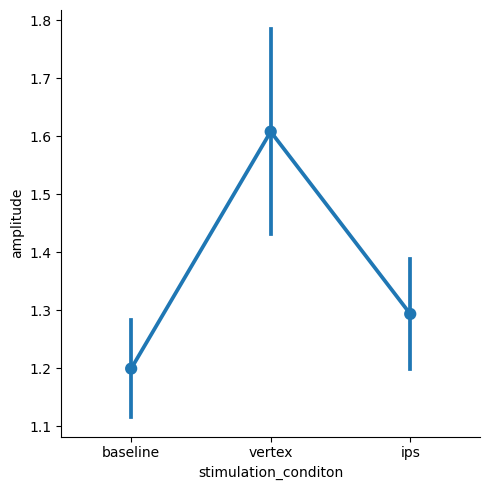

In [161]:
tmp = pars[pars.cvr2 > 0.0].groupby(['subject', 'session', 'stimulation_conditon']).mean().reset_index()


sns.catplot(tmp, x='stimulation_conditon', y='amplitude', kind='point', errorbar='se')
# tmp

In [162]:
import pingouin
pingouin.rm_anova(tmp[tmp.stimulation_conditon != 'baseline'].reset_index(), 'amplitude', 'stimulation_conditon', 'subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:742: RuntimeWarning: invalid value encountered in double_scalars
  f_a = ms_a / ms_as
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:743: RuntimeWarning: invalid value encountered in double_scalars
  f_b = ms_b / ms_bs
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:744: RuntimeWarning: invalid value encountered in double_scalars
  f_ab = ms_ab / ms_abs
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:759: RuntimeWarning: invalid value encountered in double_scalars
  ef_a = ss_a / (ss_a + ss_s + ss_as + ss_bs + ss_abs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:760: RuntimeWarning: invalid value encountered in double_scalars
  ef_b = ss_b / (ss_b + ss_s + ss_as + ss_bs + ss_abs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:761: RuntimeWarning: invalid value en

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,session,0.0,-1,1,-0.0,NaN,NaN,NaN,NaN,1.0
1,stimulation_conditon,0.0,-1,1,-0.0,NaN,NaN,NaN,NaN,1.0
2,session * stimulation_conditon,0.0,1,-1,0.0,NaN,NaN,NaN,NaN,NaN


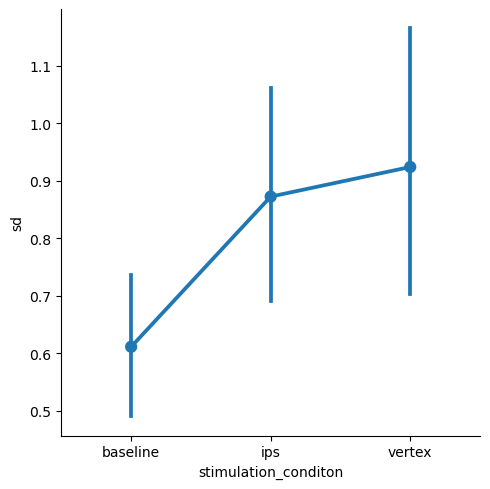

In [98]:
tmp = pars[pars.cvr2 > 0.0].groupby(['subject', 'stimulation_conditon']).mean().reset_index()


sns.catplot(tmp, x='stimulation_conditon', y='sd', kind='point')
# tmp

In [112]:
import scipy.stats as ss

In [173]:
pars.set_index(['stimulation_conditoin'], append=True)

KeyError: "None of ['stimulation_conditoin'] are in the columns"

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_52497/3518738855.py:2: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_names except for the argument 'names' will be keyword-only.
  quant.index.set_names('q', -1, inplace=True)


test
subject stimulation_conditon q            
01      baseline             0.1  1.195016
                             0.3  1.741231
                             0.5  1.823380
                             0.7  1.991713
                             0.9  2.100534
...                                    ...
74      vertex               0.1  1.130483
                             0.3  1.908557
                             0.5  2.050748
                             0.7  2.148706
                             0.9  2.420642

[505 rows x 1 columns]

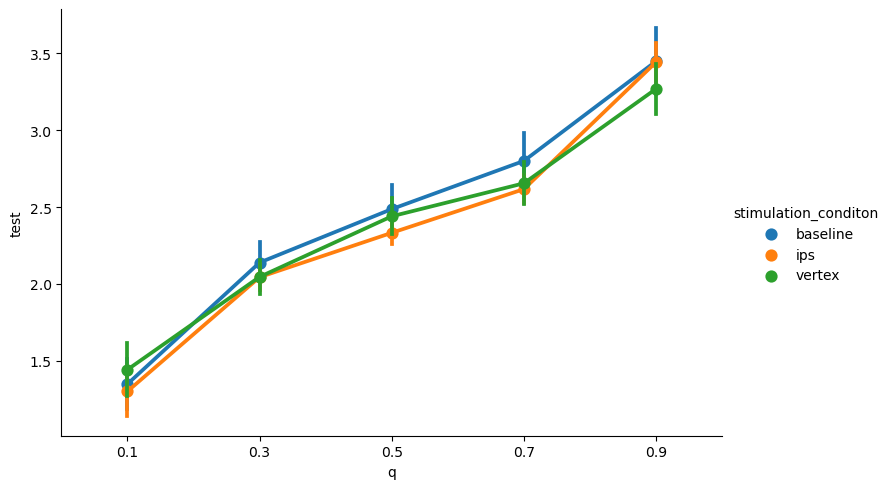

In [136]:
quant = pars[pars.cvr2 > 0.0].groupby(['subject', 'stimulation_conditon'])['mu'].apply(lambda d: d.quantile([.1, .3, .5, .7, .9]).to_frame('test'))
quant.index.set_names('q', -1, inplace=True)

sns.catplot(data=quant.reset_index(), x='q', y='test', hue='stimulation_conditon', kind='point', aspect=1.5, errorbar='se')
quant

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_52497/476700336.py:2: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_names except for the argument 'names' will be keyword-only.
  quant.index.set_names('q', -1, inplace=True)


test
subject stimulation_conditon q            
01      baseline             0.1  0.557355
                             0.3  0.871234
                             0.5  1.199469
                             0.7  1.581702
                             0.9  2.606245
...                                    ...
74      vertex               0.1  0.360716
                             0.3  0.488288
                             0.5  0.644914
                             0.7  0.900545
                             0.9  2.204908

[505 rows x 1 columns]

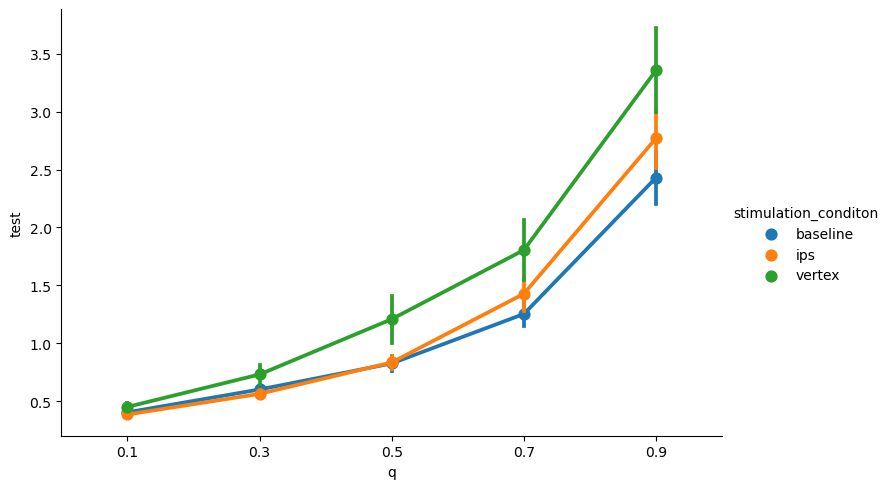

In [137]:
quant = pars[pars.cvr2 > 0.0].groupby(['subject', 'stimulation_conditon'])['amplitude'].apply(lambda d: d.quantile([.1, .3, .5, .7, .9]).to_frame('test'))
quant.index.set_names('q', -1, inplace=True)

sns.catplot(data=quant.reset_index(), x='q', y='test', hue='stimulation_conditon', kind='point', aspect=1.5, errorbar='se')
quant

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_52497/3169357681.py:2: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_names except for the argument 'names' will be keyword-only.
  quant.index.set_names('q', -1, inplace=True)


test
subject stimulation_conditon q            
01      baseline             0.1  1.115619
                             0.3  1.795099
                             0.5  1.960339
                             0.7  2.100882
                             0.9  3.398606
...                                    ...
74      vertex               0.1  0.616281
                             0.3  1.930997
                             0.5  2.215861
                             0.7  2.670761
                             0.9  4.254682

[505 rows x 1 columns]

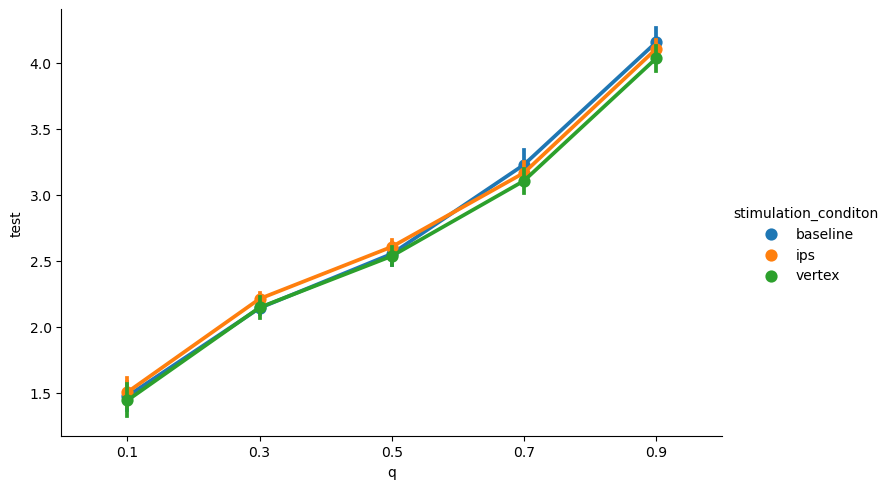

In [132]:
quant = pars[pars.cvr2 > -100.0].groupby(['subject', 'stimulation_conditon'])['mu'].apply(lambda d: d.quantile([.1, .3, .5, .7, .9]).to_frame('test'))
quant.index.set_names('q', -1, inplace=True)

sns.catplot(data=quant.reset_index(), x='q', y='test', hue='stimulation_conditon', kind='point', aspect=1.5, errorbar='se')
quant

In [60]:
cvr2['stimulation_conditon'] = cvr2.reset_index().apply(lambda d: tms_conditions[d['subject']][d['session']],  axis=1)

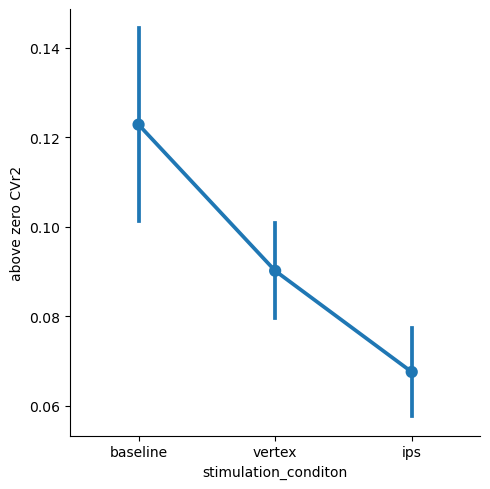

In [61]:
sns.catplot(cvr2.reset_index(), x='stimulation_conditon', y='above zero CVr2', kind='point', errorbar='se')

In [108]:
(pars.unstack('session')['cvr2'] > 0.0).mean()

session
1    0.123084
2    0.074386
3    0.076585
dtype: float64

In [63]:
import pingouin

pingouin.rm_anova(data=cvr2[cvr2.stimulation_conditon != 'baseline'], dv='above zero CVr2', within='stimulation_conditon', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_conditon,1,31,3.60398,0.066985,0.033042,1.0


In [64]:
tmp = pars.unstack('session')

tmp = tmp.loc[tmp[('cvr2', 1)] > 0.0]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/g

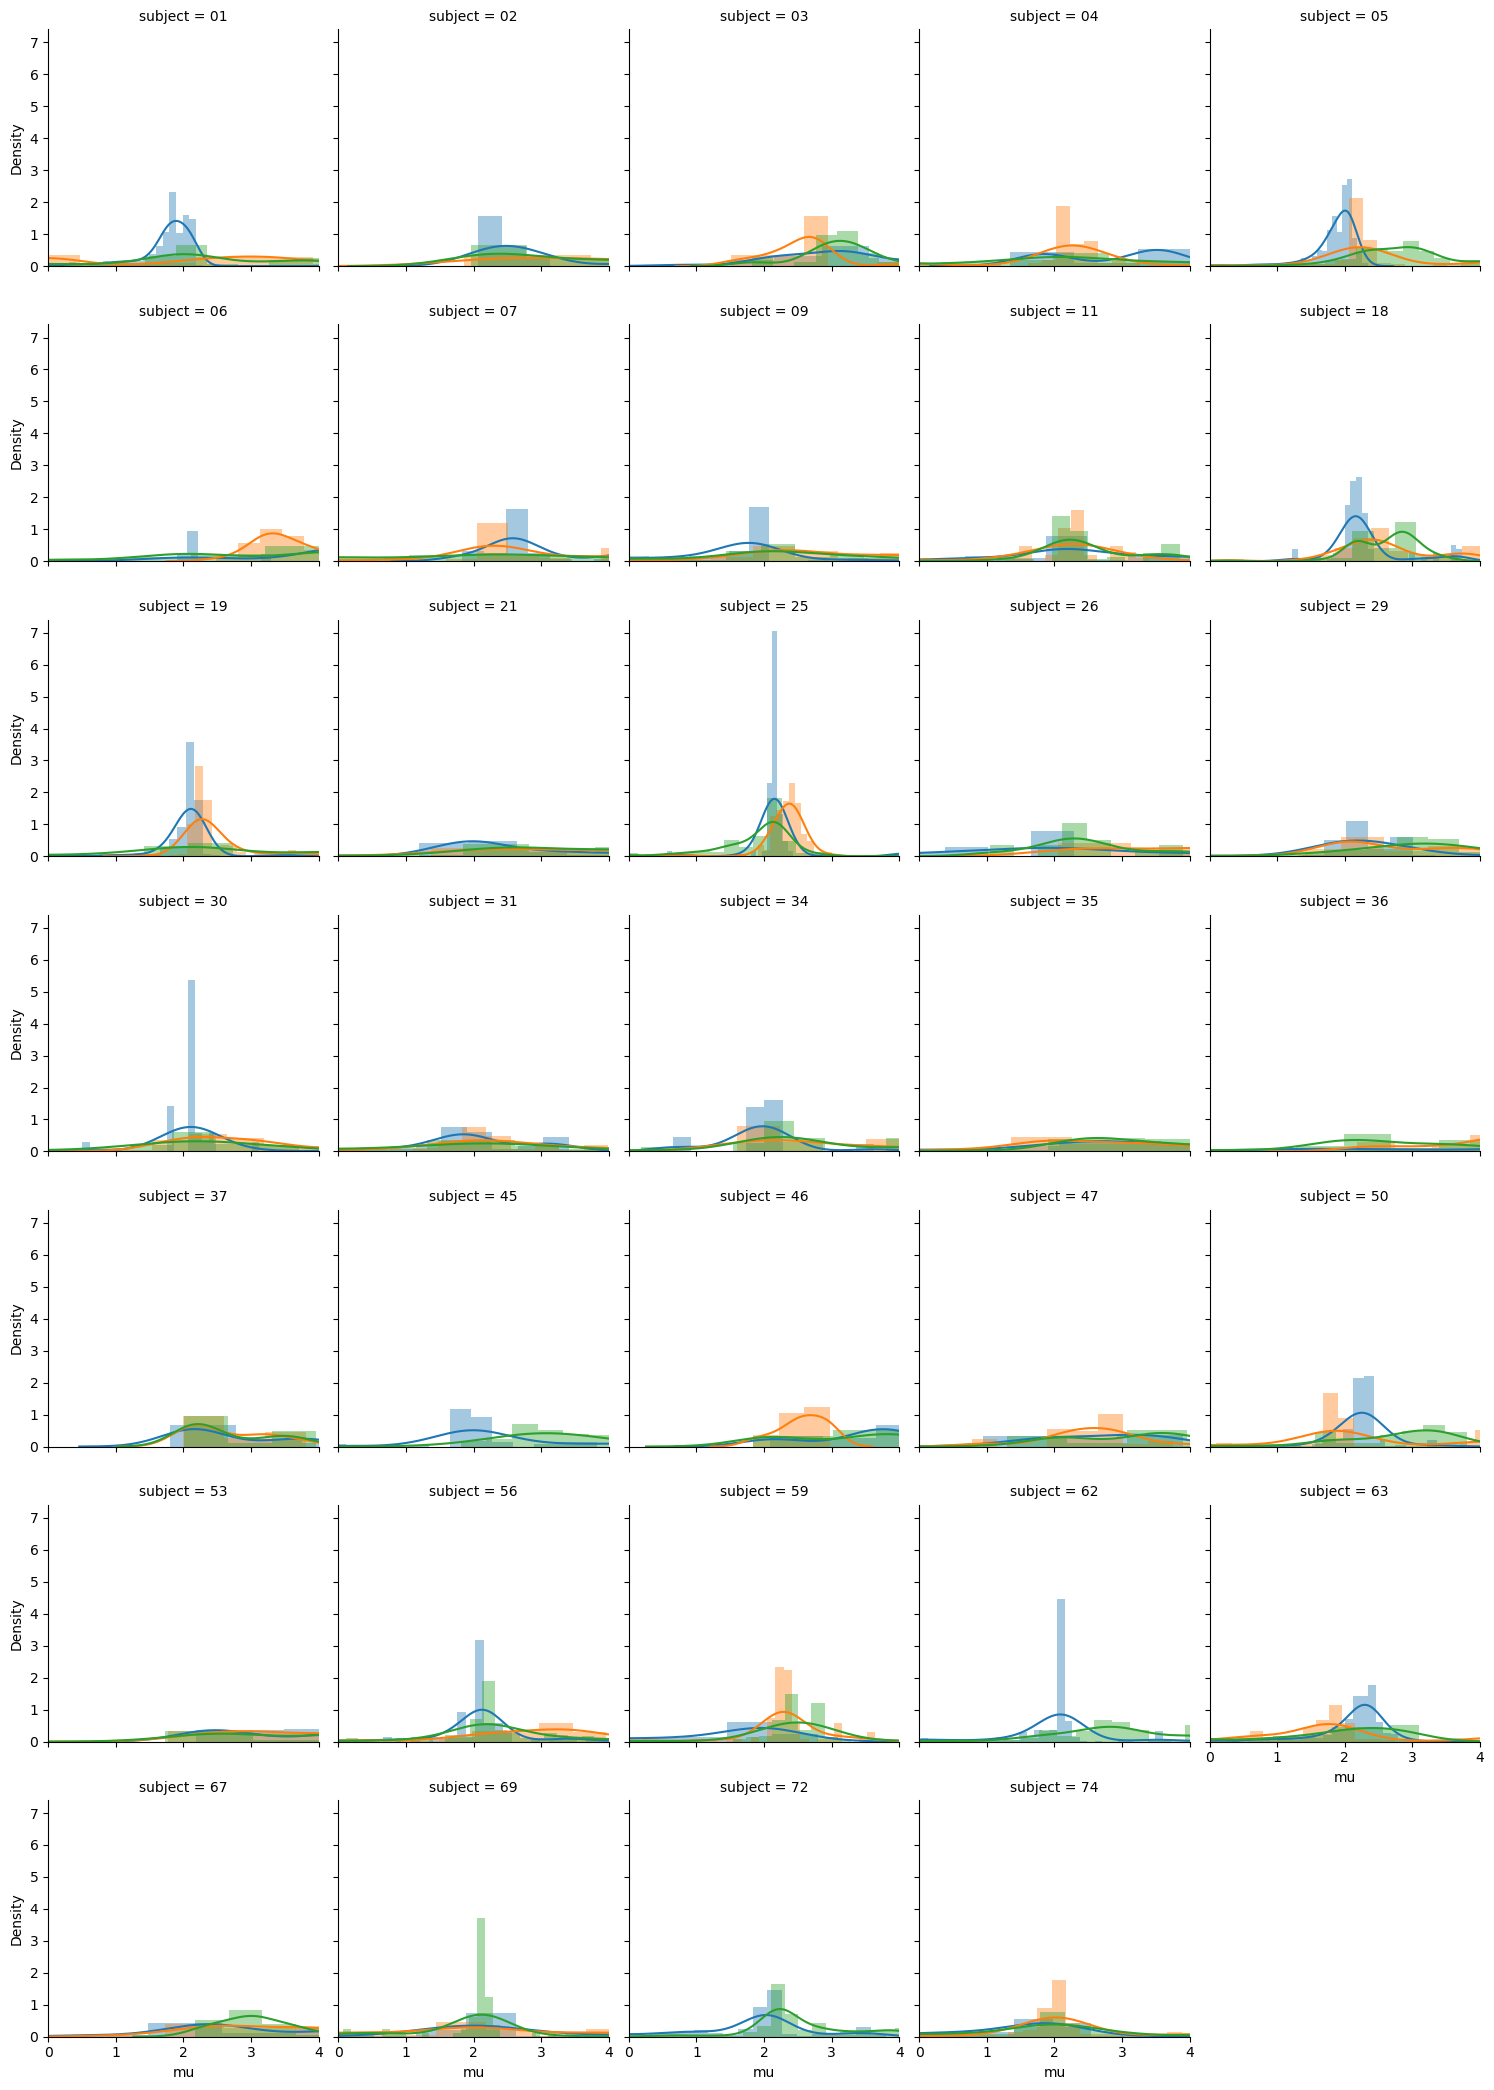

In [65]:
fac = sns.FacetGrid(tmp.stack('session').reset_index(), col='subject', hue='session', col_wrap=5)

fac.map(sns.distplot, 'mu')
fac.set(xlim=(0, 4))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/g

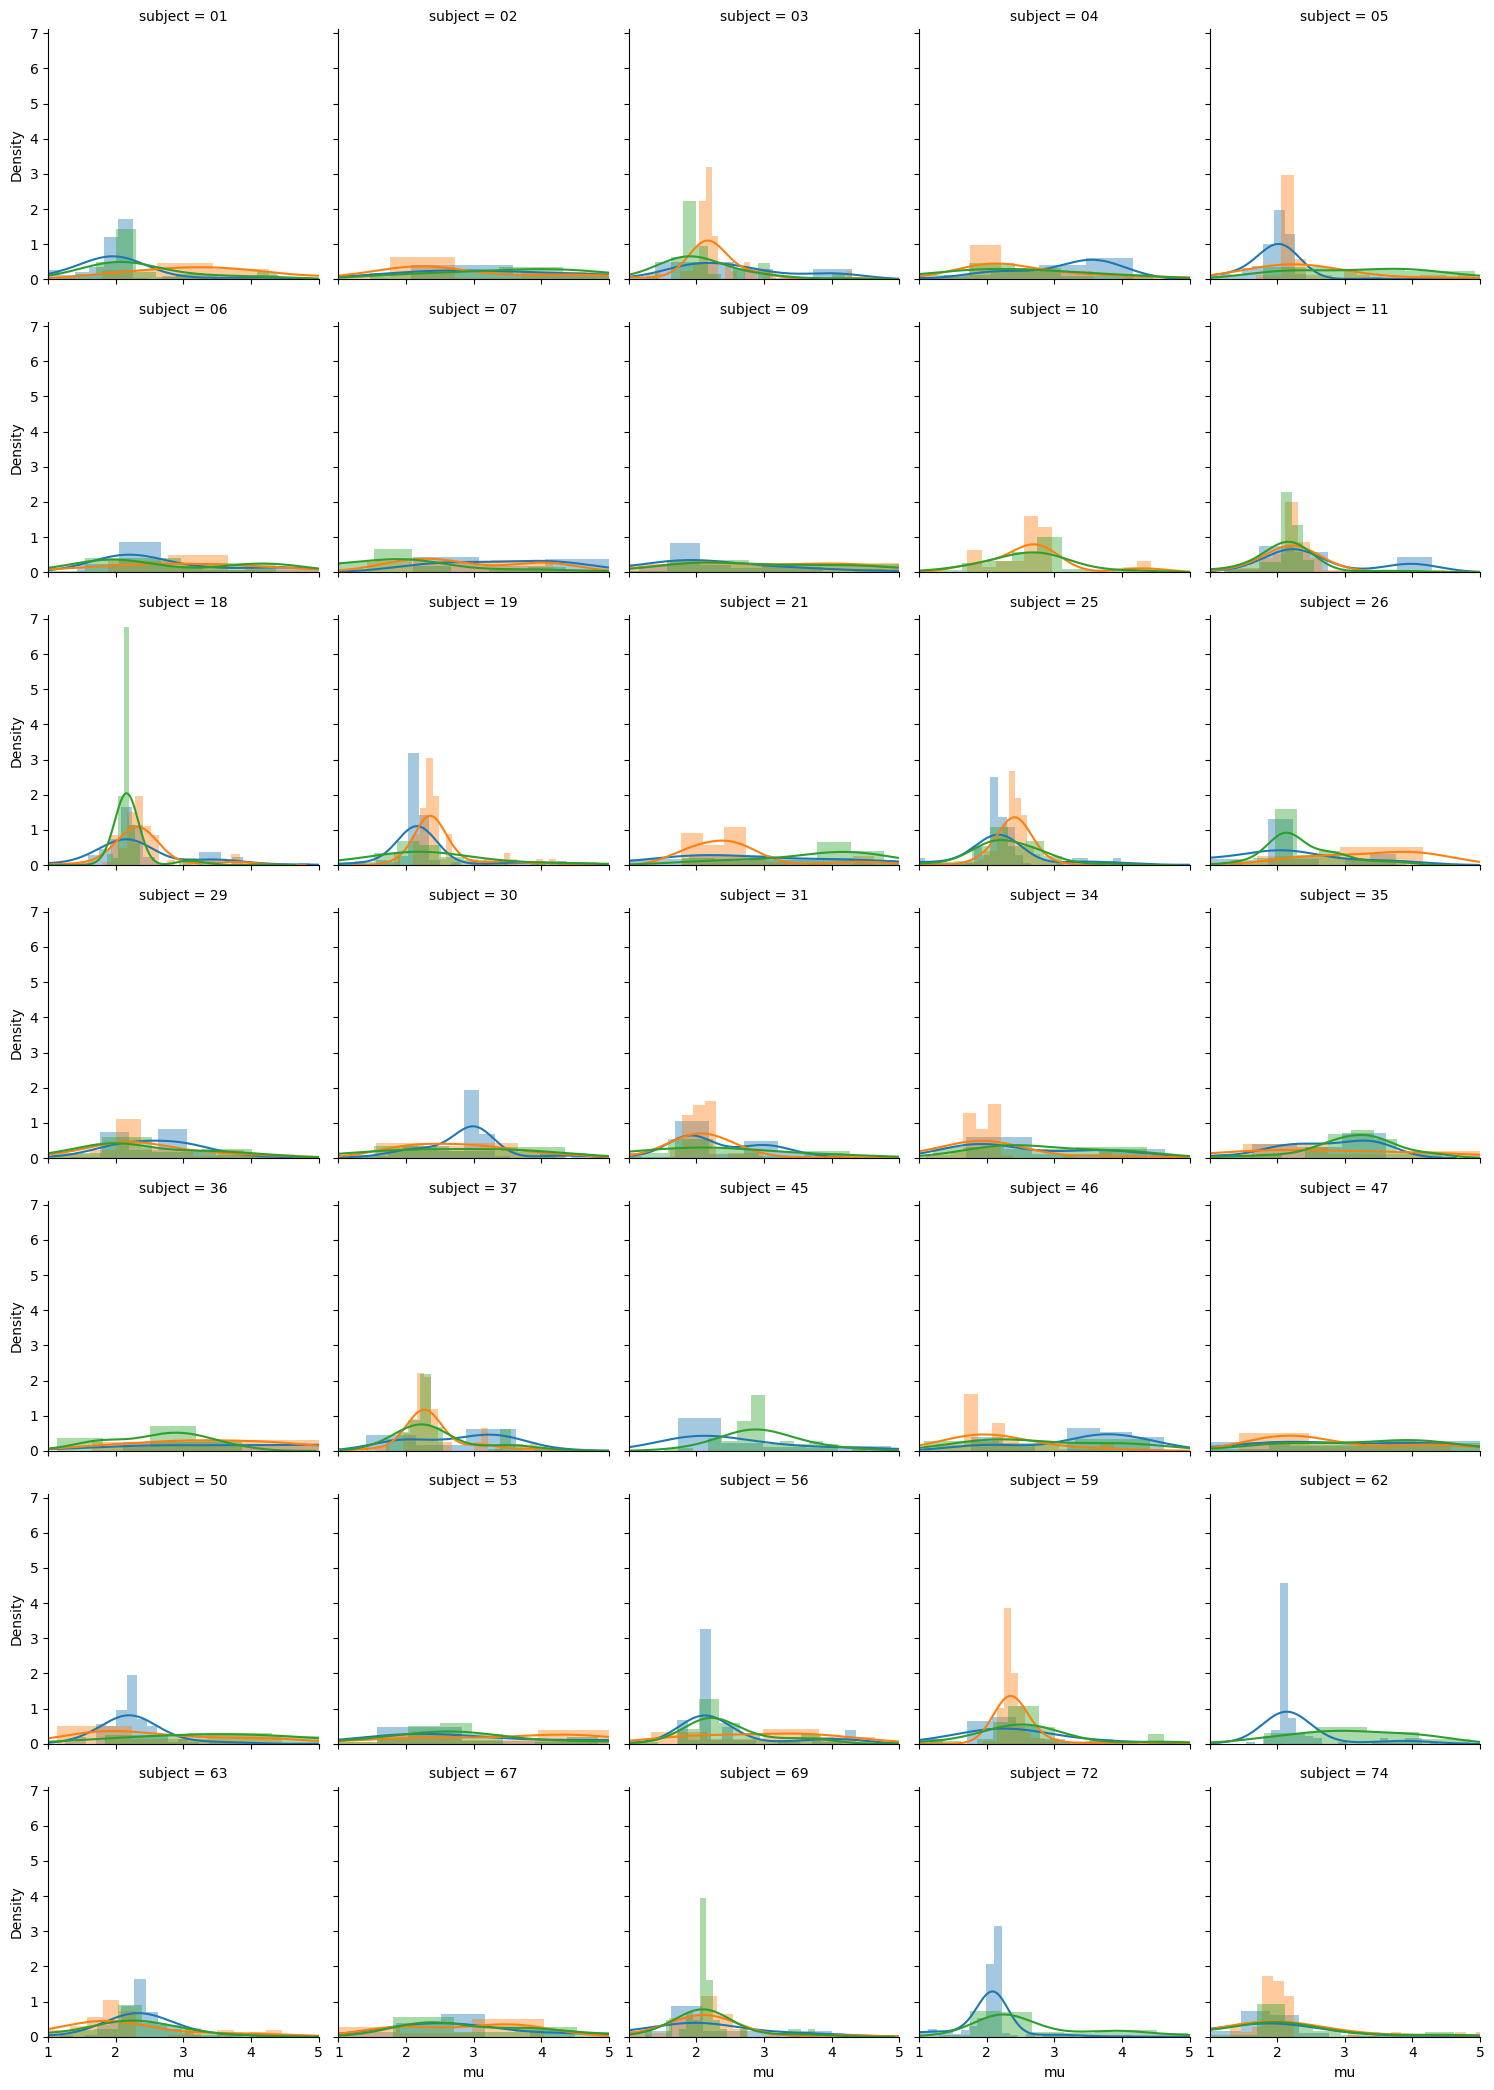

In [29]:
tmp = pars.copy()

tmp = tmp.loc[tmp['cvr2'] > 0.0].reset_index()

fac = sns.FacetGrid(tmp, col='subject', hue='session', col_wrap=5)

fac.map(sns.distplot, 'mu')
fac.set(xlim=(1, 5))

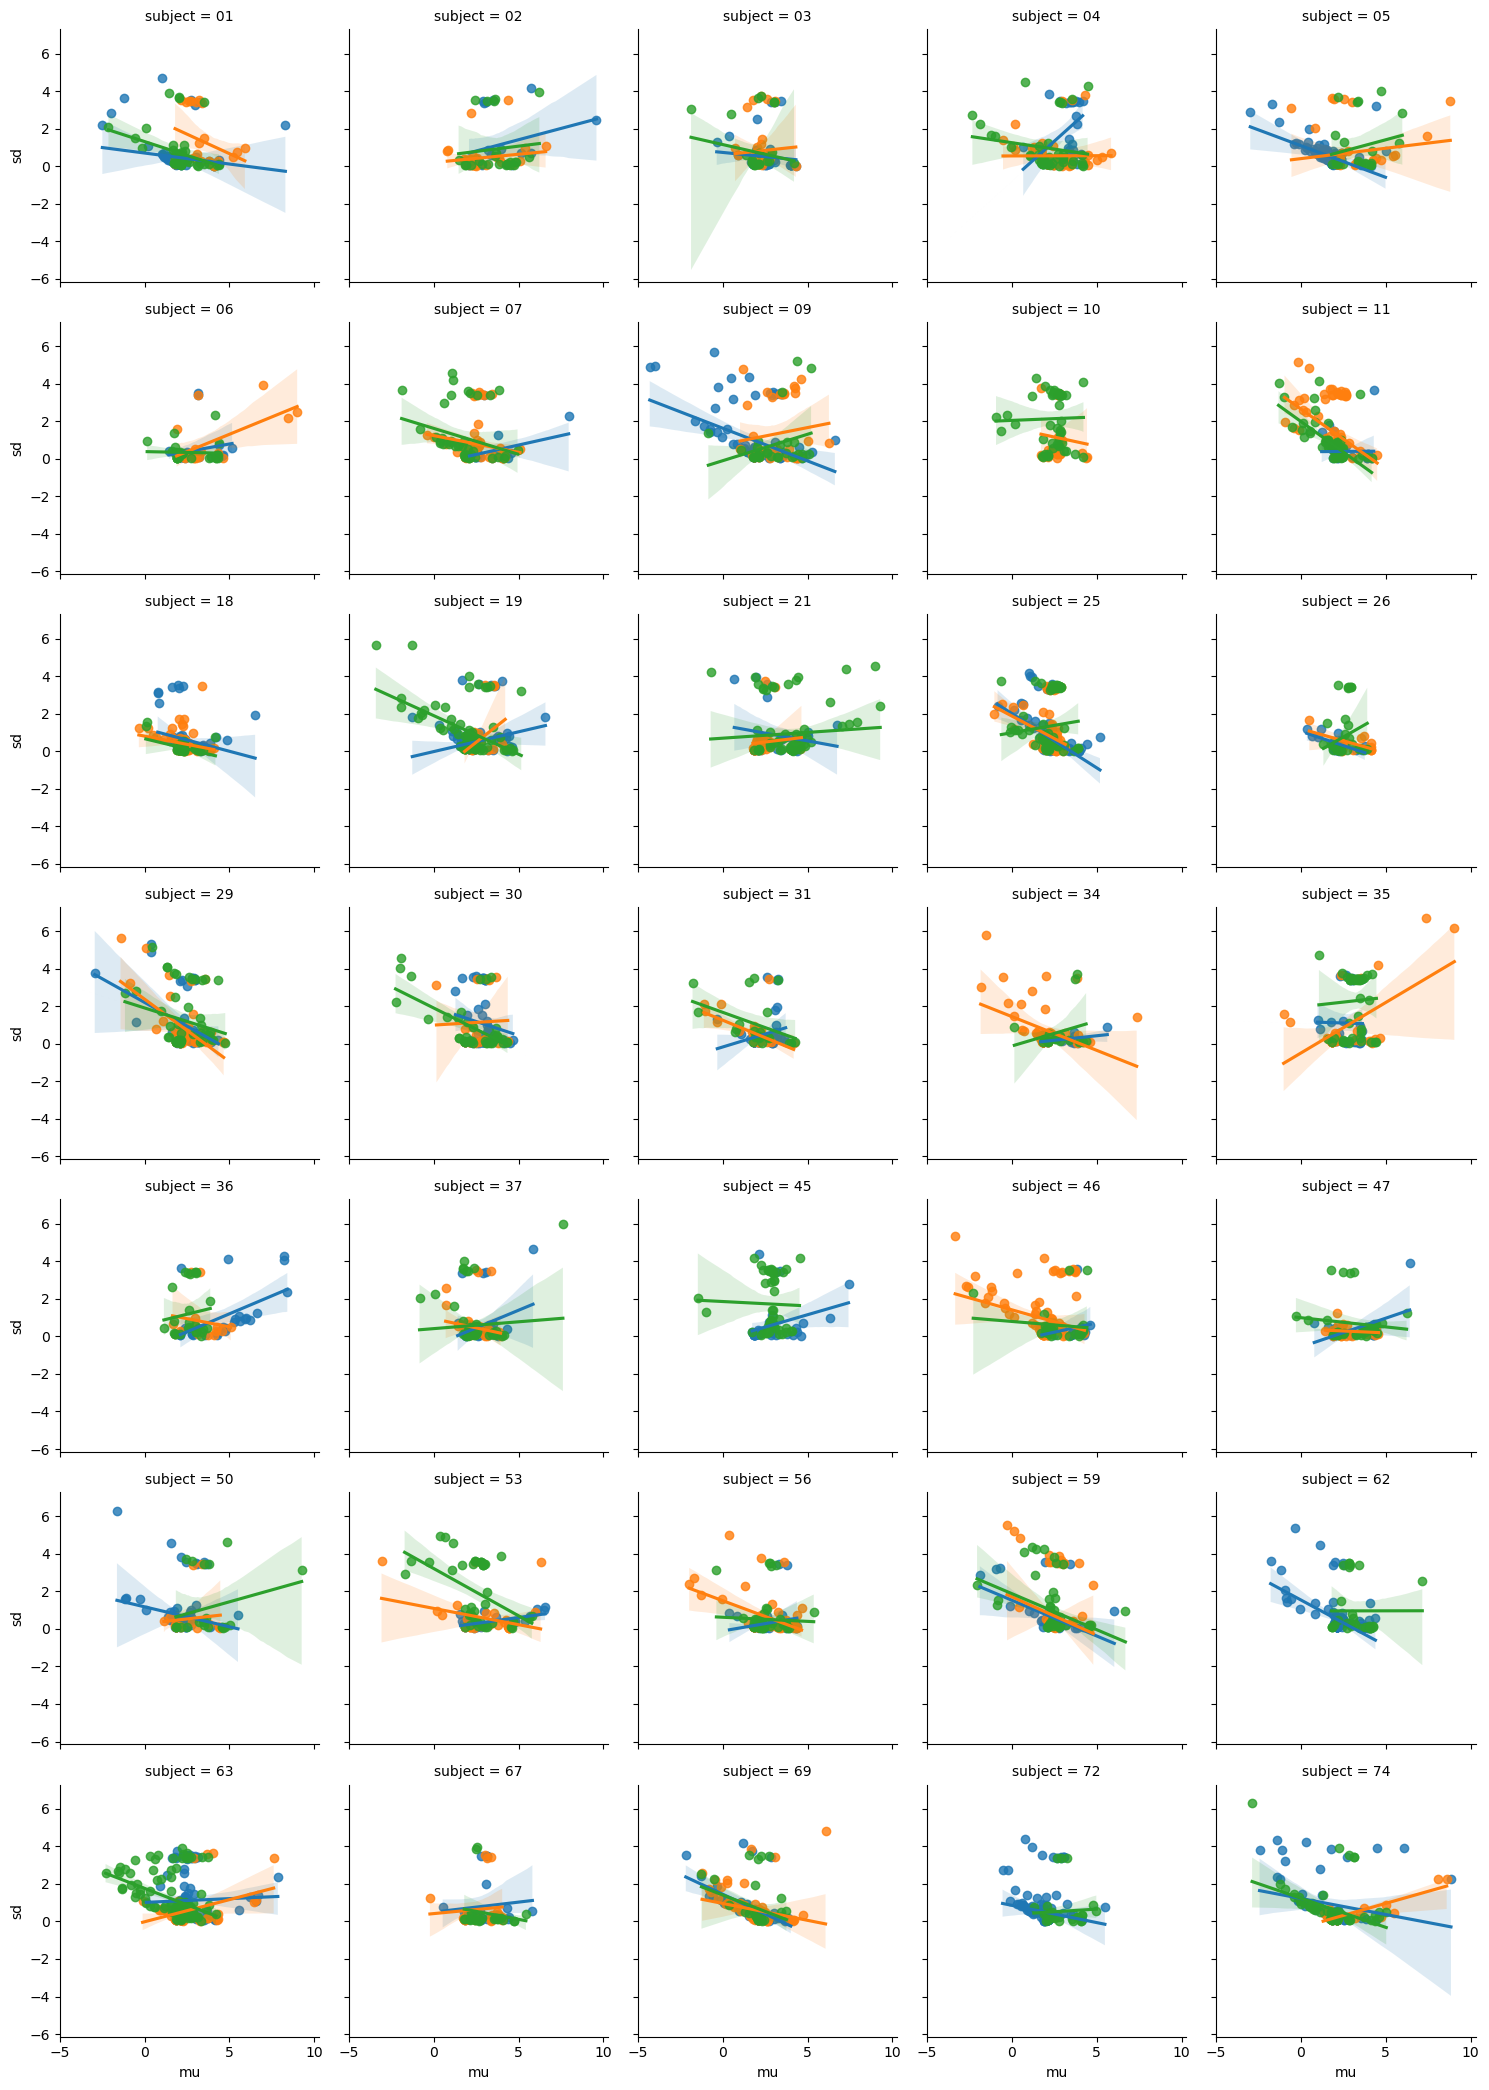

In [30]:
tmp = pars.copy()

tmp = tmp.loc[tmp['cvr2'] > 0.0].reset_index()

fac = sns.FacetGrid(tmp, col='subject', hue='session', col_wrap=5)

fac.map(sns.regplot, 'mu', 'sd')
# fac.set(xlim=(1, 5))

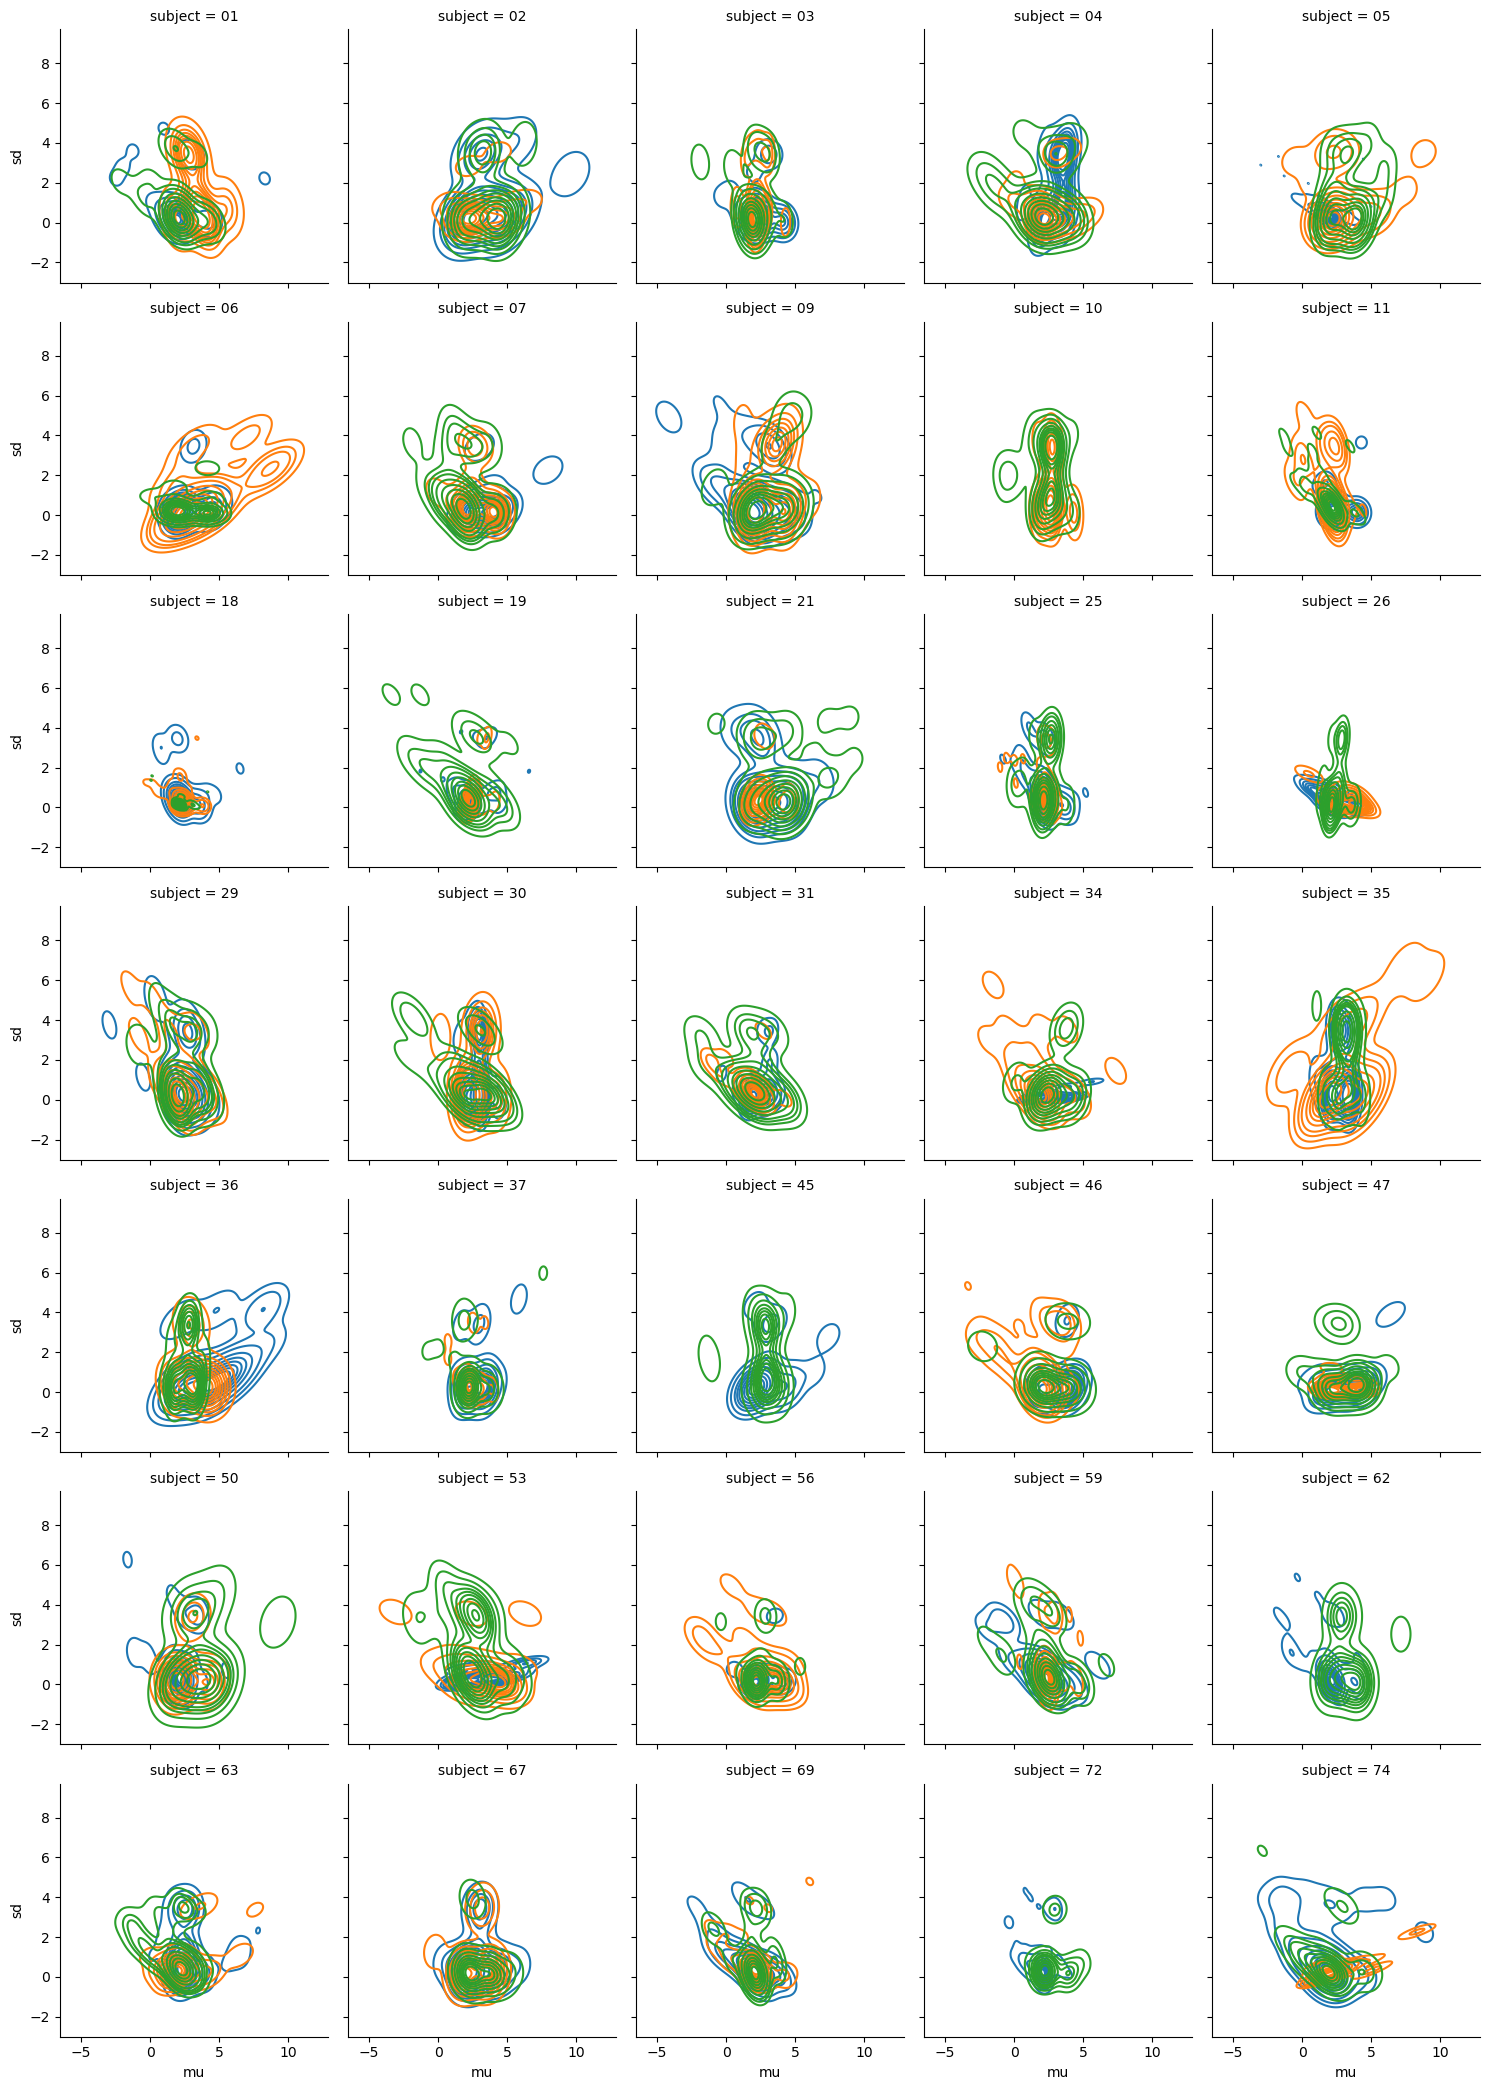

In [31]:
tmp = pars.copy()

tmp = tmp.loc[tmp['cvr2'] > 0.0].reset_index()

fac = sns.FacetGrid(tmp, col='subject', hue='session', col_wrap=5)

fac.map(sns.kdeplot, 'mu', 'sd')
# fac.set(xlim=(1, 5))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/g

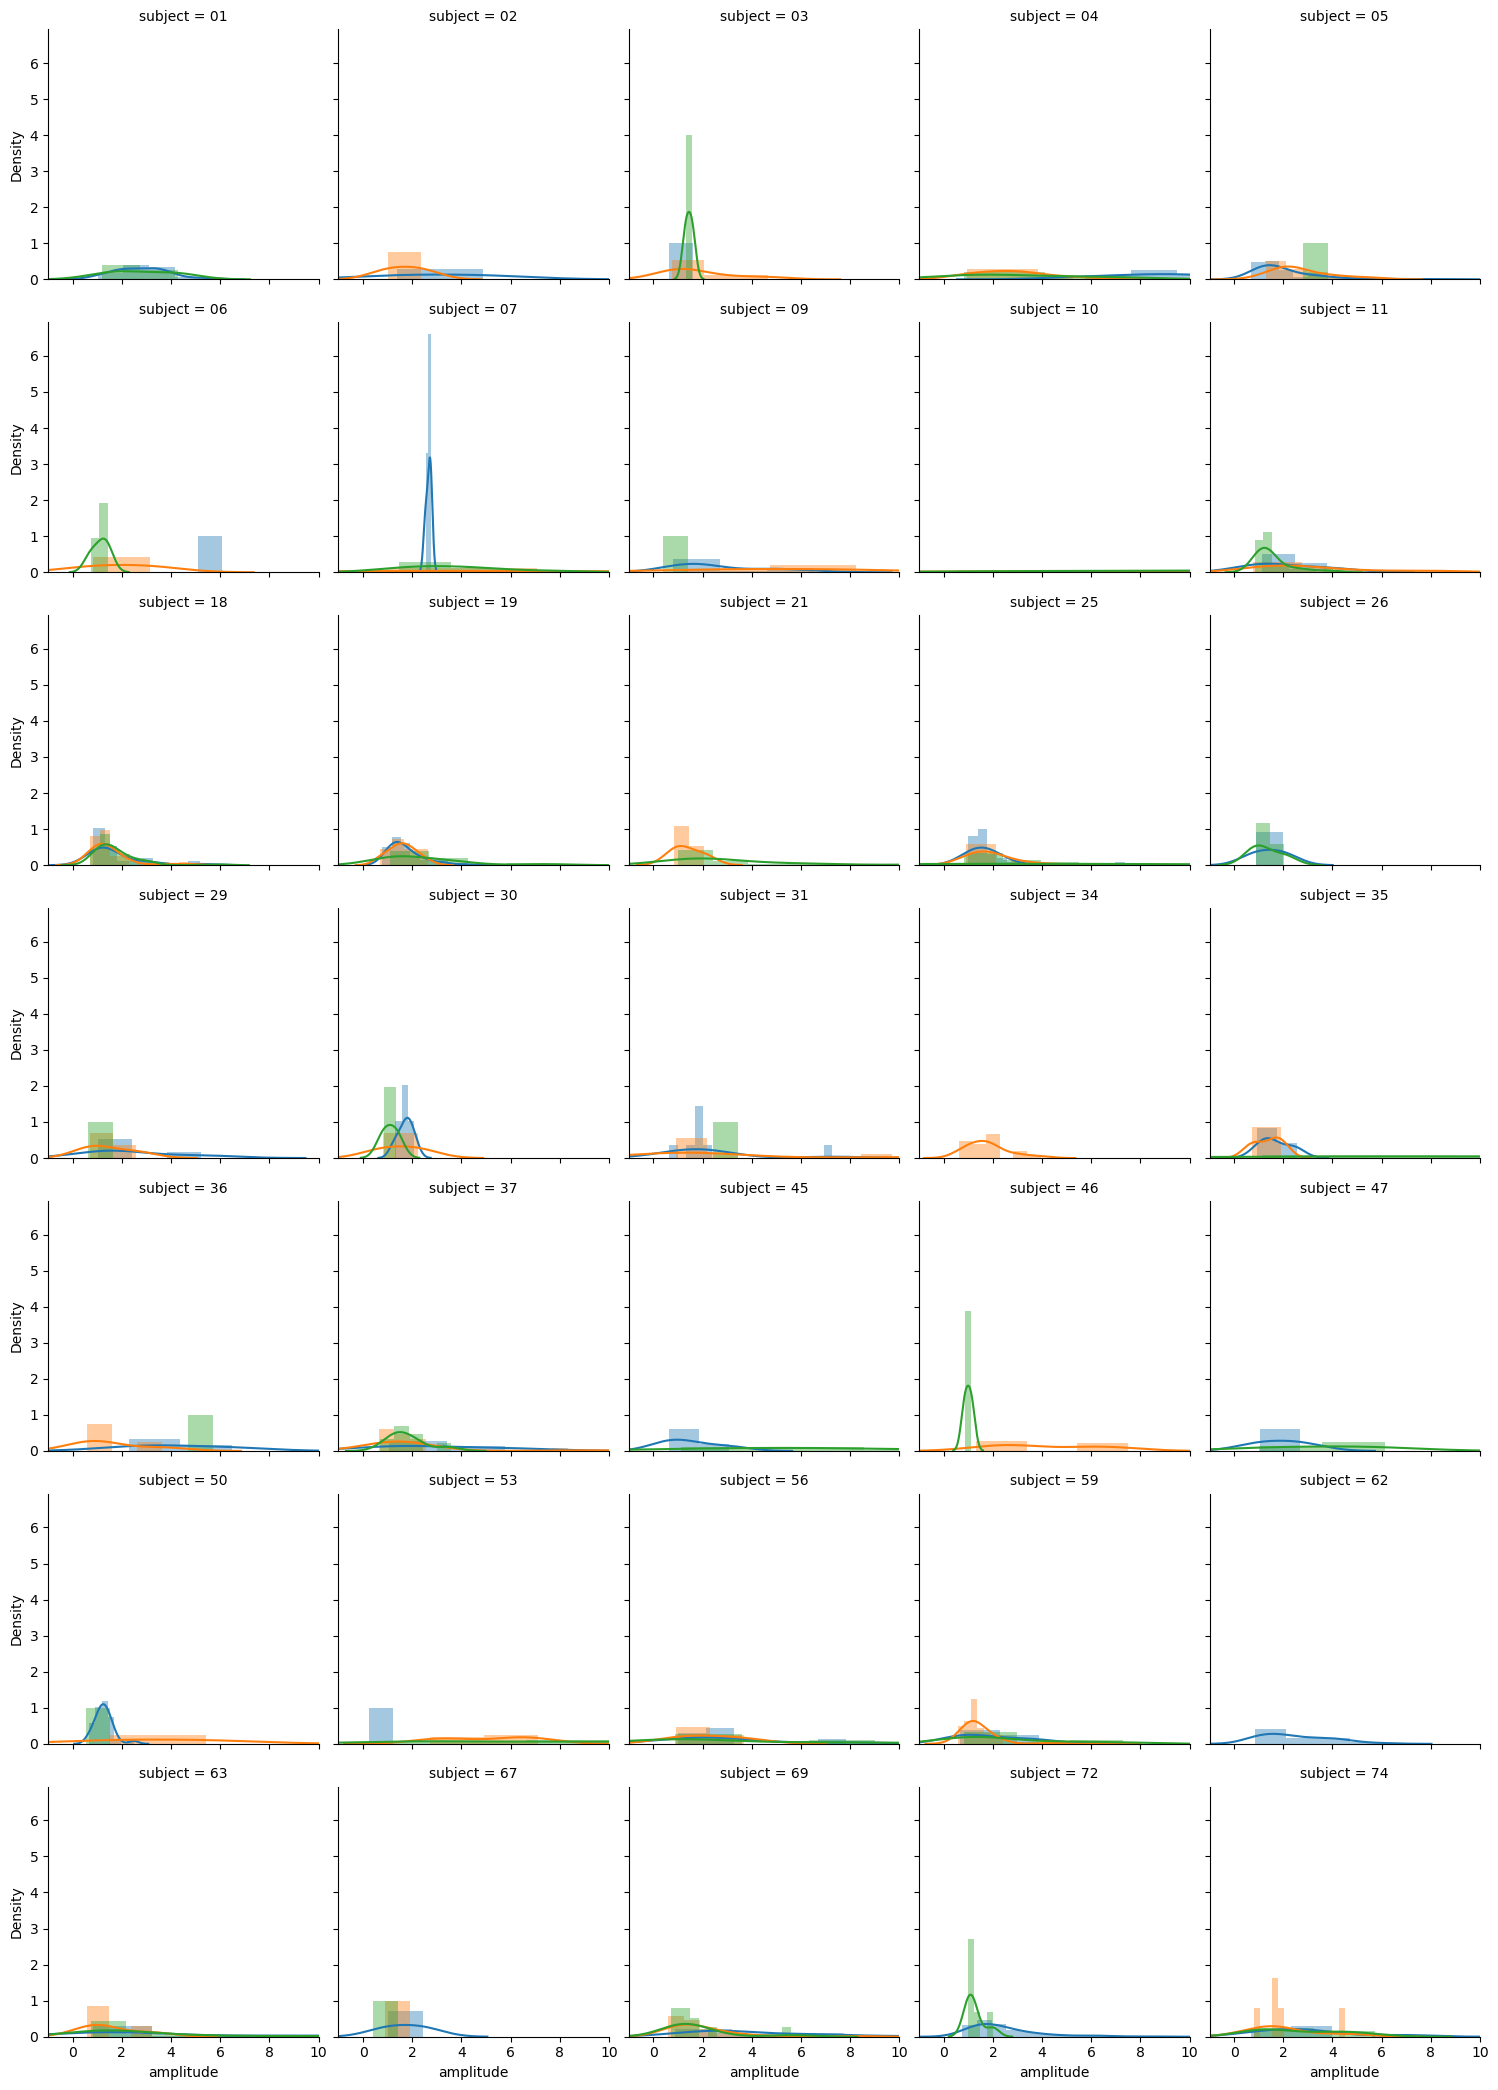

In [32]:
tmp = pars.copy()

tmp = tmp.loc[tmp['cvr2'] > 0.05].reset_index()

fac = sns.FacetGrid(tmp, col='subject', hue='session', col_wrap=5)

fac.map(sns.distplot, 'amplitude')
fac.set(xlim=(-1, 10))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserW

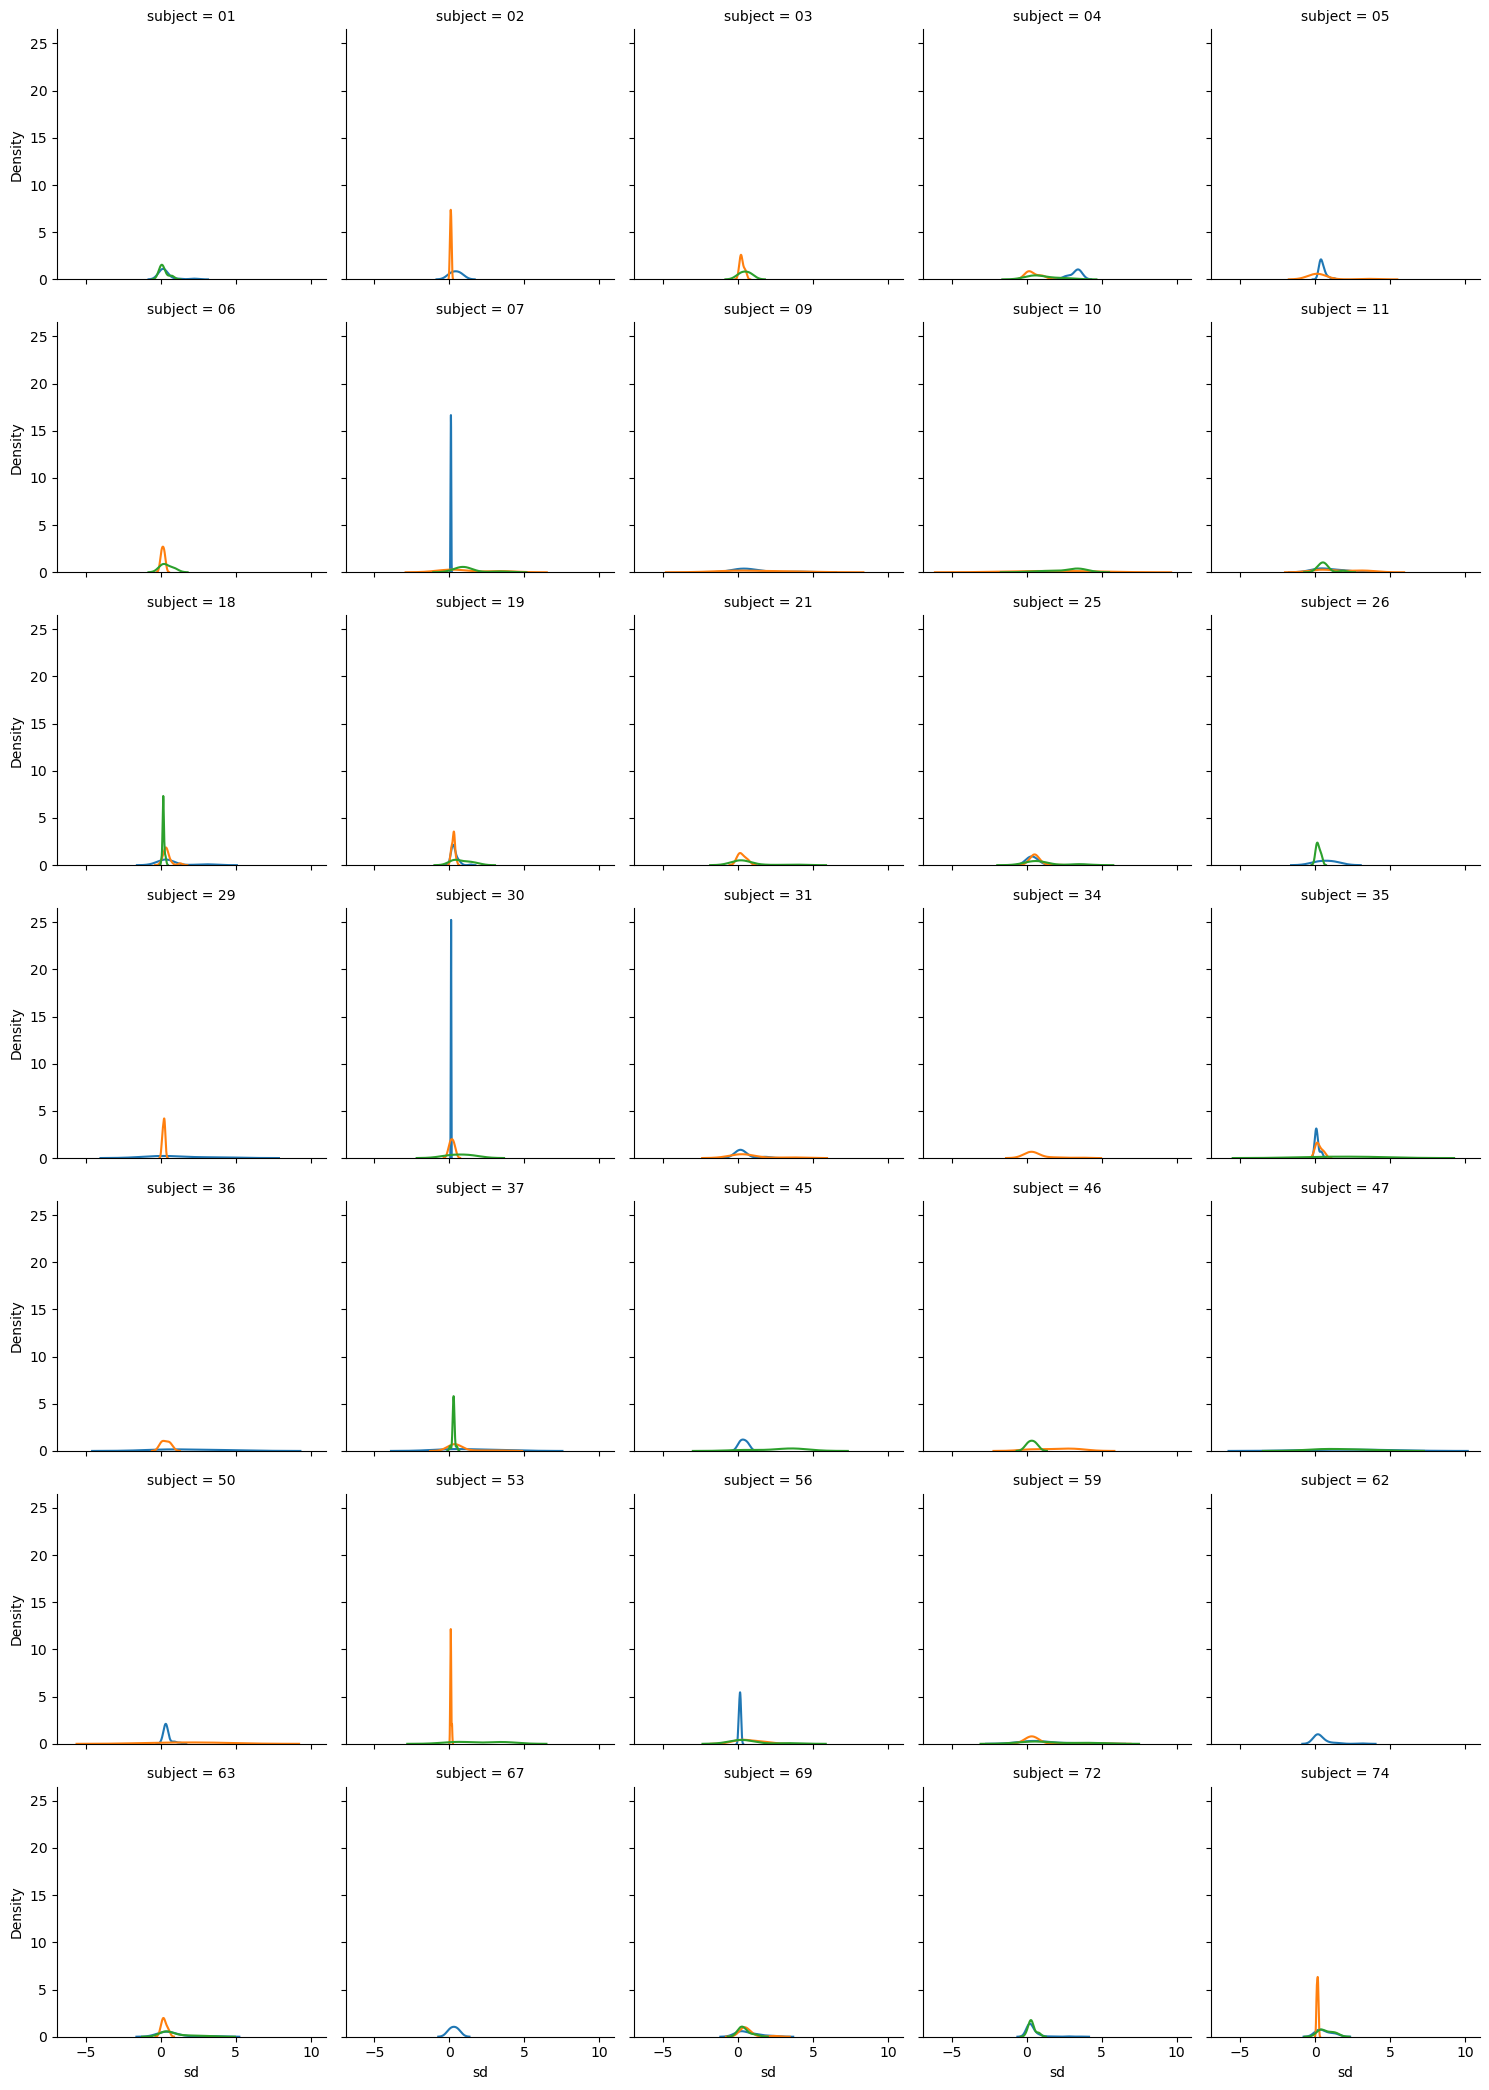

In [33]:
tmp = pars.copy()

tmp = tmp.loc[tmp['cvr2'] > 0.05].reset_index()

fac = sns.FacetGrid(tmp, col='subject', hue='session', col_wrap=5)

fac.map(sns.kdeplot, 'sd')
# fac.set(xlim=(-1, 10))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserW

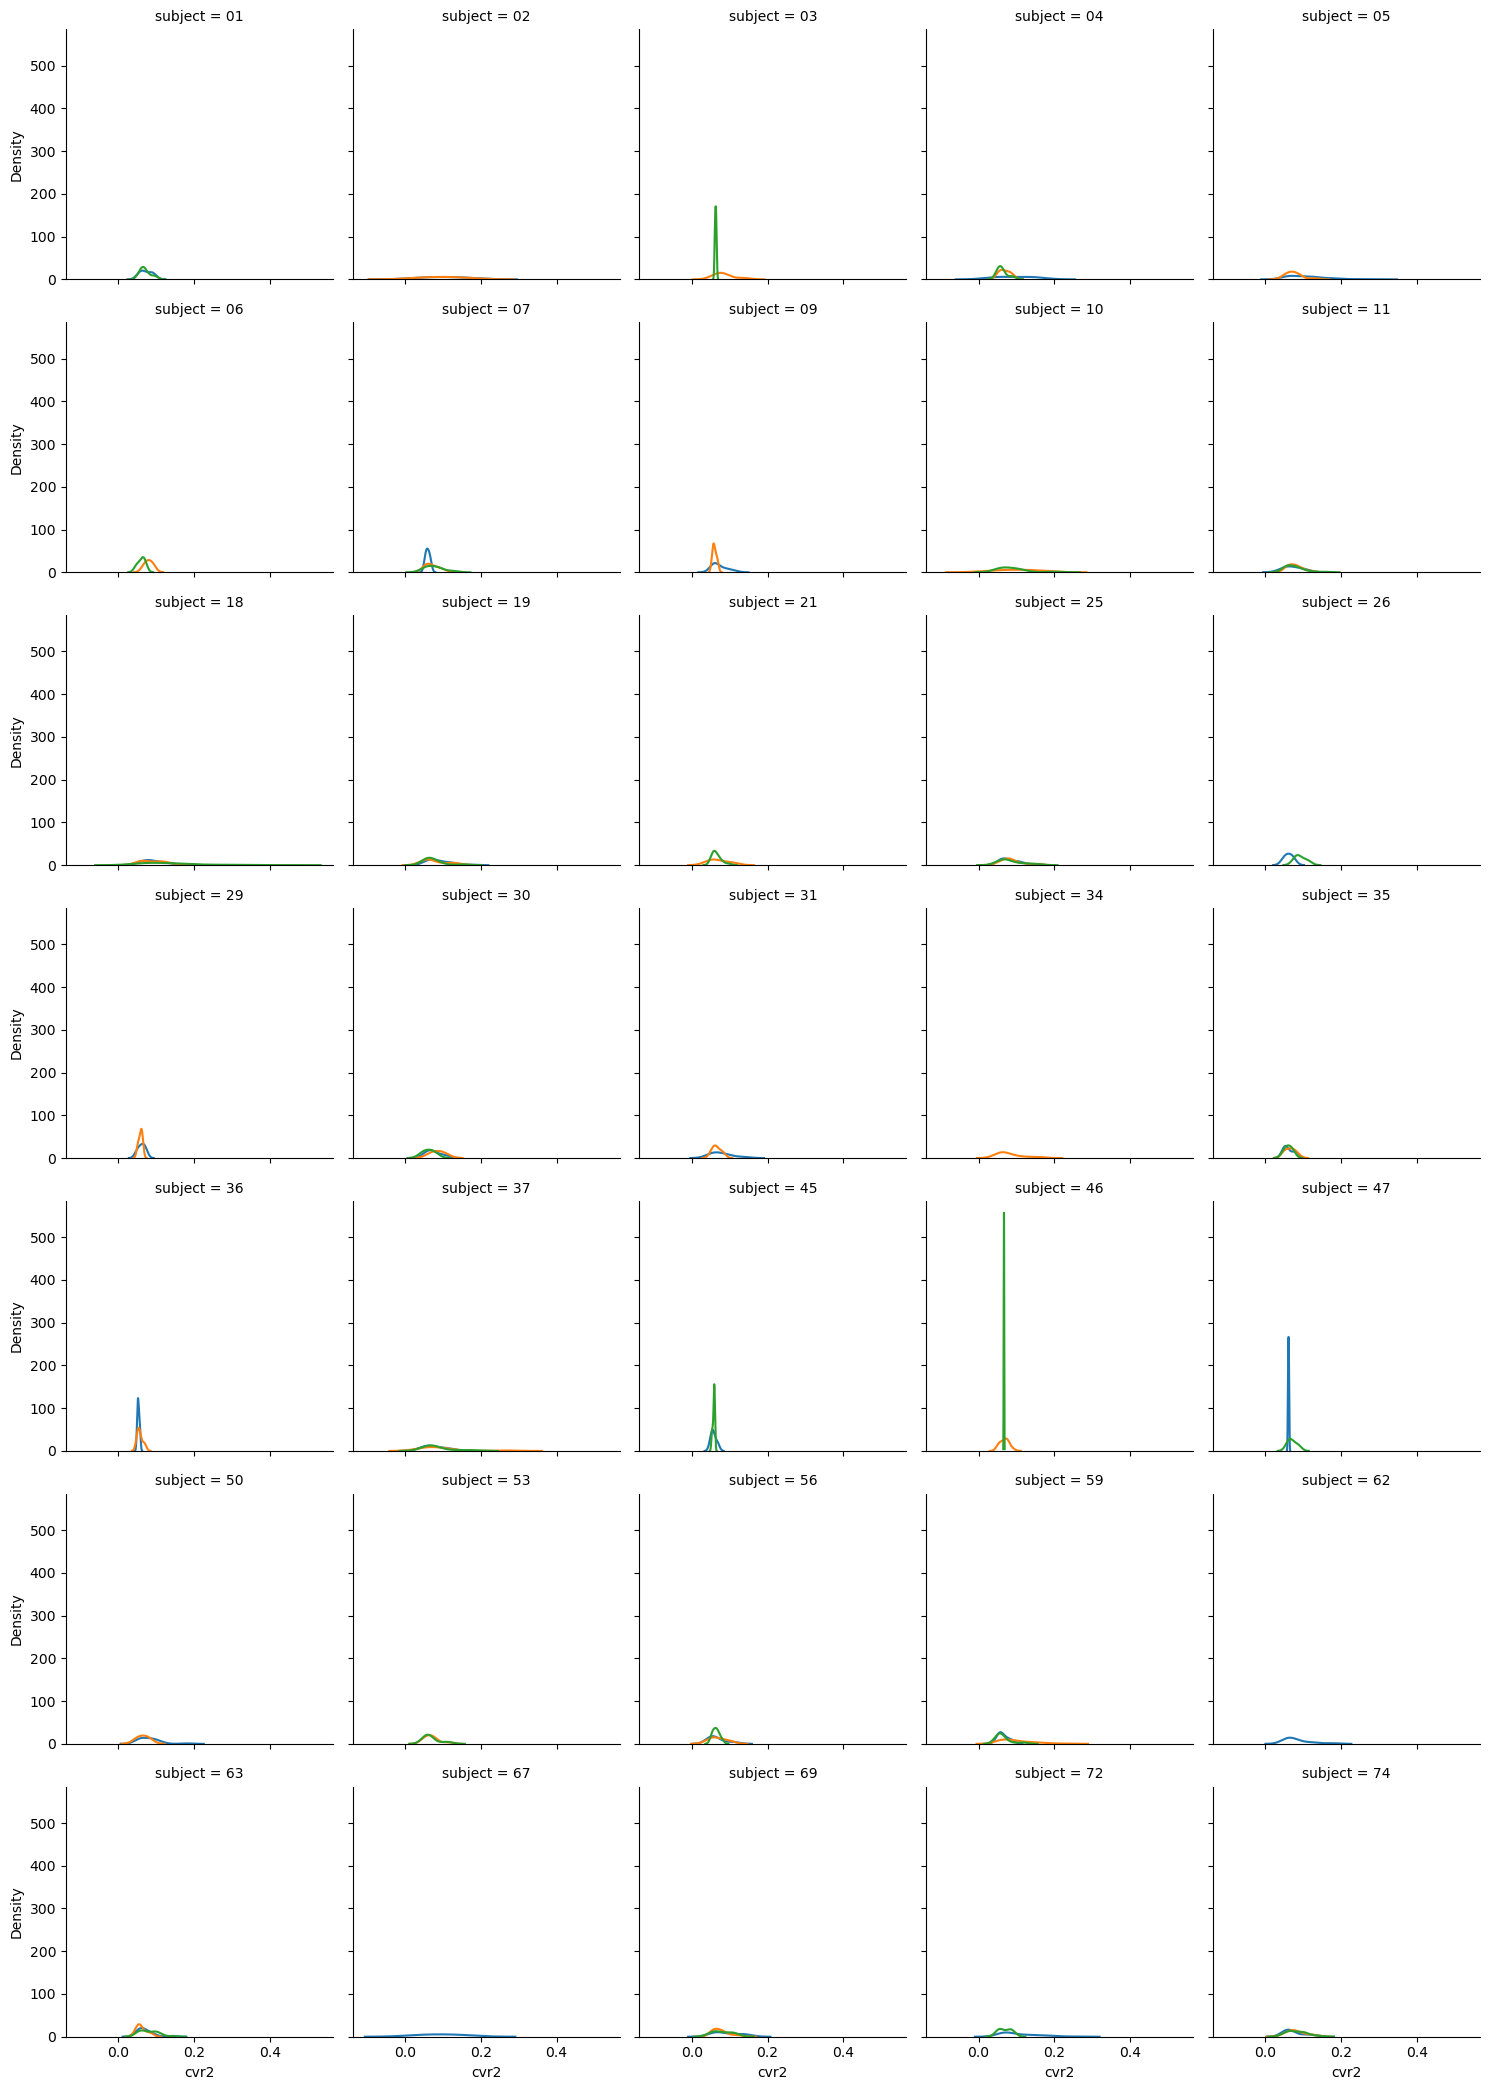

In [34]:
tmp = pars.copy()

tmp = tmp.loc[tmp['cvr2'] > 0.05].reset_index()

fac = sns.FacetGrid(tmp, col='subject', hue='session', col_wrap=5)

fac.map(sns.kdeplot, 'cvr2')
# fac.set(xlim=(-1, 10))